This script sets your Google Drive credentials and the target folder ID, creates local folders for downloads and graphs, and installs any missing libraries. It then connects to Google Drive, searches the folder and all subfolders, and picks only .txt log files whose names include “LOG”, “PSP”, and “UTC”. Matching files are downloaded to the local cache (skipping ones you already have). Finally, it prints how many log files were found.

In [1]:
# ============================================================================
# AIR QUALITY DATA ANALYSIS - 
# ============================================================================

import os
from pathlib import Path
import sys
import subprocess
from io import StringIO
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# STEP 1: BASIC SETUP
# ============================================================================

import os
from pathlib import Path
import sys

# Search for credentials in multiple locations (for team flexibility)
possible_credential_paths = [
    Path.home() / "capstone_credentials.json",  # Recommended location (~/capstone_credentials.json)
    Path.cwd() / "capstonefall2025-d459579c25fc.json",  # Only works locally (NOT in repo)
    Path(os.getenv("CAPSTONE_SA_JSON", "")),  # Optional environment variable
]

credentials_file = None
for path in possible_credential_paths:
    if path.exists():
        credentials_file = path
        print(f"Using credentials: {path}")
        break

if not credentials_file:
    raise FileNotFoundError(
        "Credentials not found!\n\n"
        "Please:\n"
        "1. Get 'capstonefall2025-XXXXX.json' from the team (via Slack/email)\n"
        "2. Save it to: ~/capstone_credentials.json\n"
        "3. Make sure it's NOT in the Git repo folder\n"
        "4. Re-run this cell"
    )

drive_folder_id = "1YNujfIm14j_lMgDodoV8cvQksWZu_gdy"

os.environ["CAPSTONE_SA_JSON"] = str(credentials_file)
os.environ["CAPSTONE_FOLDER_ID"] = drive_folder_id

print("Working directory:", Path.cwd())

# ============================================================================
# STEP 2: INSTALL REQUIRED LIBRARIES
# ============================================================================

try:
    import pydrive2
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pydrive2", "--quiet"])

try:
    from oauth2client.service_account import ServiceAccountCredentials
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "oauth2client", "--quiet"])
    from oauth2client.service_account import ServiceAccountCredentials

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# ============================================================================
# STEP 3: CONNECT TO GOOGLE DRIVE
# ============================================================================

def login_to_drive(credentials_path):
    """Connect to Google Drive using service account credentials"""
    if not Path(credentials_path).exists():
        raise FileNotFoundError(f"Credentials file not found: {credentials_path}")
    
    scopes = ["https://www.googleapis.com/auth/drive.readonly"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_path, scopes)
    
    auth = GoogleAuth()
    auth.credentials = creds
    return GoogleDrive(auth)

# ============================================================================
# STEP 4: FIND FILES IN GOOGLE DRIVE 
# ============================================================================

def find_all_log_files_in_folder(drive, folder_id):
    """Find all air quality log files in Google Drive (without downloading)"""
    
    FOLDER_TYPE = "application/vnd.google-apps.folder"
    folders_to_check = [folder_id]
    log_files = []
    
    while folders_to_check:
        current_folder = folders_to_check.pop()
        
        # Find subfolders
        subfolders = drive.ListFile({
            'q': f"'{current_folder}' in parents and mimeType='{FOLDER_TYPE}' and trashed=false"
        }).GetList()
        
        for folder in subfolders:
            folders_to_check.append(folder['id'])
        
        # Find files
        files = drive.ListFile({
            'q': f"'{current_folder}' in parents and mimeType!='{FOLDER_TYPE}' and trashed=false"
        }).GetList()
        
        for file_info in files:
            filename = file_info.get("name") or file_info.get("title")
            
            if not filename:
                continue
            
            # Check if this is a log file we want
            filename_upper = filename.upper()
            is_log_file = (filename_upper.endswith(".TXT") and 
                          "LOG" in filename_upper and 
                          "PSP" in filename_upper and 
                          "UTC" in filename_upper)
            
            if is_log_file:
                log_files.append({
                    'id': file_info['id'],
                    'name': filename,
                    'file_obj': file_info
                })
    
    return sorted(log_files, key=lambda x: x['name'])

Using credentials: /home/jovyan/capstone_credentials.json
Working directory: /home/jovyan/Capstone/Air_Q


This part of the code provides helper functions to make the raw log files usable. First, it looks for the section called “SAMPLE LOG”, finds the column headers (like DateTimeUTC), and loads the data into a pandas DataFrame. Any error codes such as -9999 are turned into missing values so they don’t break the analysis. The code then tries different ways to figure out the timestamps (from UTC, UnixTime, or local time) and to identify the device ID (from the folder name, filename, or file text). It also estimates the start time of the measurement either from the log summary, the first timestamp, or the filename, and formats both the date and the hour into readable labels.


In [2]:
# ============================================================================
# STEP 5: HELPER FUNCTIONS TO READ AND PROCESS DATA
# ============================================================================

def read_air_quality_log_from_drive(drive_file_info, drive):
    """Read an air quality log file directly from Google Drive (in-memory)"""
    
    # Get file content directly into memory
    file_obj = drive.CreateFile({'id': drive_file_info['id']})
    content = file_obj.GetContentString()
    
    # Split into lines
    lines = content.splitlines()
    
    # Find where the data table starts (marked by "SAMPLE LOG")
    try:
        sample_log_line = lines.index("SAMPLE LOG")
    except ValueError:
        raise RuntimeError(f"'SAMPLE LOG' not found in {drive_file_info['name']}")
    
    # Find the column headers (contains "DateTimeUTC")
    header_line = None
    for i in range(sample_log_line + 1, min(sample_log_line + 25, len(lines))):
        if "DateTimeUTC" in lines[i]:
            header_line = i
            break
    
    if header_line is None:
        raise RuntimeError(f"Column headers not found in {drive_file_info['name']}")
    
    # Extract data starting after the units line
    data_start = header_line + 2
    csv_data = lines[header_line] + "\n" + "\n".join(lines[data_start:])
    
    # Convert to pandas DataFrame
    df = pd.read_csv(StringIO(csv_data))
    
    # Replace error values (-9999) with NaN
    df = df.replace([-9999.0, -9999], np.nan)
    
    return df, lines, drive_file_info['name']

def get_device_name_from_drive(filename, file_lines):
    """Figure out which device/sensor this data is from"""
    
    # Try to find in filename (e.g., PSP00298)
    filename_match = re.search(r"PSP(\d{5})", filename, re.IGNORECASE)
    if filename_match:
        return filename_match.group(1).upper()
    
    # Try to find in file content
    for line in file_lines[:200]:
        if line.startswith("UPASserial"):
            parts = line.split(",")
            if len(parts) > 1:
                return "".join(c for c in parts[1] if c.isdigit()) or parts[1].strip()
    
    # Default: use first part of filename
    return filename.split("_")[0]

def get_timestamps(df):
    """Extract timestamp column from data"""
    
    # Try DateTimeUTC column
    utc_col = next((c for c in df.columns if "DateTimeUTC" in c), None)
    if utc_col:
        timestamps = pd.to_datetime(df[utc_col], format="%Y-%m-%dT%H:%M:%S", errors="coerce", utc=True)
        if timestamps.notna().any():
            return timestamps
    
    # Try UnixTime column
    if "UnixTime" in df.columns:
        timestamps = pd.to_datetime(pd.to_numeric(df["UnixTime"], errors="coerce"), unit="s", utc=True)
        if timestamps.notna().any():
            return timestamps
    
    # Try DateTimeLocal column
    local_col = next((c for c in df.columns if "DateTimeLocal" in c), None)
    if local_col:
        return pd.to_datetime(df[local_col], errors="coerce")
    
    # If no timestamps found, return index numbers
    return pd.Series(range(len(df)), index=df.index)

def get_start_time(file_lines, df, filename):
    """Get the start time of the measurement"""
    
    # Try to find in SAMPLE SUMMARY section
    try:
        summary_line = file_lines.index("SAMPLE SUMMARY")
        for i in range(summary_line, min(summary_line + 80, len(file_lines))):
            if file_lines[i].startswith("StartDateTimeLocal,"):
                time_str = file_lines[i].split(",")[1].strip()
                start_time = pd.to_datetime(time_str, errors="coerce")
                if pd.notna(start_time):
                    return start_time
                break
    except ValueError:
        pass
    
    # Try first timestamp in data
    local_col = next((c for c in df.columns if "DateTimeLocal" in c), None)
    if local_col:
        timestamps = pd.to_datetime(df[local_col], errors="coerce")
        if timestamps.notna().any():
            return timestamps.dropna().iloc[0]
    
    # Try to extract from filename
    filename_match = re.match(
        r"PSP\d+_LOG_(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})UTC",
        filename,
        re.IGNORECASE
    )
    if filename_match:
        time_str = filename_match.group(1).replace("_", ":")
        return pd.to_datetime(time_str, errors="coerce")
    
    return None

def format_hour(timestamp):
    """Format timestamp as hour (e.g., '2 PM')"""
    if timestamp is None or pd.isna(timestamp):
        return "?"
    return timestamp.round("h").strftime("%I %p").lstrip("0").upper()

def format_date(timestamp):
    """Format timestamp as date (e.g., '2024-10-15')"""
    if timestamp is None or pd.isna(timestamp):
        return "unknown-date"
    return timestamp.strftime("%Y-%m-%d")


This step reads each log, keeps only entries with valid PM2.5 and timestamps, and computes “minutes since start” for a common time axis. It tags each record with device, date, and hour, then concatenates all files into one clean DataFrame.

This step builds clear line plots of PM2.5 vs. time. It groups the combined data by date and hour bucket, then for each group it opens a new figure and plots one line per file/device on the same axes. Each series is sorted by minutes since start to draw a clean curve.

In [5]:
# ============================================================================
# STEP 6: PROCESS ALL FILES AND PREPARE DATA
# ============================================================================

print("\nConnecting to Google Drive...")
drive = login_to_drive(os.environ["CAPSTONE_SA_JSON"])

print("Finding log files...")
log_files = find_all_log_files_in_folder(drive, os.environ["CAPSTONE_FOLDER_ID"])
print(f"Found {len(log_files)} log files\n")

# Process all files
all_data = []

for file_info in log_files:
    try:
        # Read file
        df, file_lines, filename = read_air_quality_log_from_drive(file_info, drive)
        
        # Get device name
        device = get_device_name_from_drive(filename, file_lines)
        
        # Get start time for labeling
        timestamps = get_timestamps(df)
        start_time = get_start_time(file_lines, df, filename)
        
        # Get PM2.5 data - look for PM2_5MC (with underscore, not dot!)
        pm25_col = next((c for c in df.columns if "PM2_5MC" in c and "Var" not in c), None)
        
        if pm25_col is None:
            print(f"✗ Skipping {filename} - No PM2_5MC column found")
            continue
        
        pm25 = pd.to_numeric(df[pm25_col], errors="coerce")
        
        # Create records using timestep instead of minutes
        count = 0
        for i in range(len(df)):
            if pd.notna(pm25.iloc[i]):
                all_data.append({
                    "device": device,
                    "file": filename,
                    "date": format_date(start_time),
                    "hour_bucket": format_hour(start_time),
                    "timestep": i + 1,  # Use sample number (1, 2, 3, ...)
                    "pm25": pm25.iloc[i]
                })
                count += 1
        
        print(f"✓ Processed {filename}: {count} data points")
        
    except Exception as e:
        import traceback
        print(f"✗ Error in {file_info['name']}: {e}")

# Convert to DataFrame
data = pd.DataFrame(all_data)
print(f"\n{'='*60}")
print(f"SUMMARY: Total data points: {len(data)}")
if len(data) > 0:
    print(f"Devices: {data['device'].unique()}")
    print(f"Dates: {data['date'].unique()}")
print(f"{'='*60}\n")


Connecting to Google Drive...
Finding log files...
Found 30 log files

✓ Processed PSP00037_LOG_2025-10-10T17_14_08UTC_---------------_----------.txt: 73 data points
✓ Processed PSP00037_LOG_2025-10-14T16_06_47UTC_---------------_----------.txt: 117 data points
✓ Processed PSP00037_LOG_2025-10-15T01_09_46UTC_---------------_----------.txt: 73 data points
✓ Processed PSP00037_LOG_2025-10-16T15_42_32UTC_---------------_----------.txt: 97 data points
✓ Processed PSP00037_LOG_2025-10-16T18_18_03UTC_---------------_----------.txt: 74 data points
✓ Processed PSP00205_LOG_2025-10-01T19_57_24UTC_---------------_----------.txt: 65 data points
✓ Processed PSP00205_LOG_2025-10-02T15_14_15UTC_---------------_----------.txt: 116 data points
✓ Processed PSP00205_LOG_2025-10-02T18_04_45UTC_---------------_----------.txt: 106 data points
✓ Processed PSP00205_LOG_2025-10-10T17_14_09UTC_________________----------.txt: 73 data points
✓ Processed PSP00205_LOG_2025-10-14T16_05_47UTC_---------------_------


 CREATE GRAPHS time steps vs pm2.5 ( all data from 10/1)



Creating graphs (displaying in notebook, not saving)...
Total data points: 2623
Devices found: ['00037' '00205' '00298' '00389']


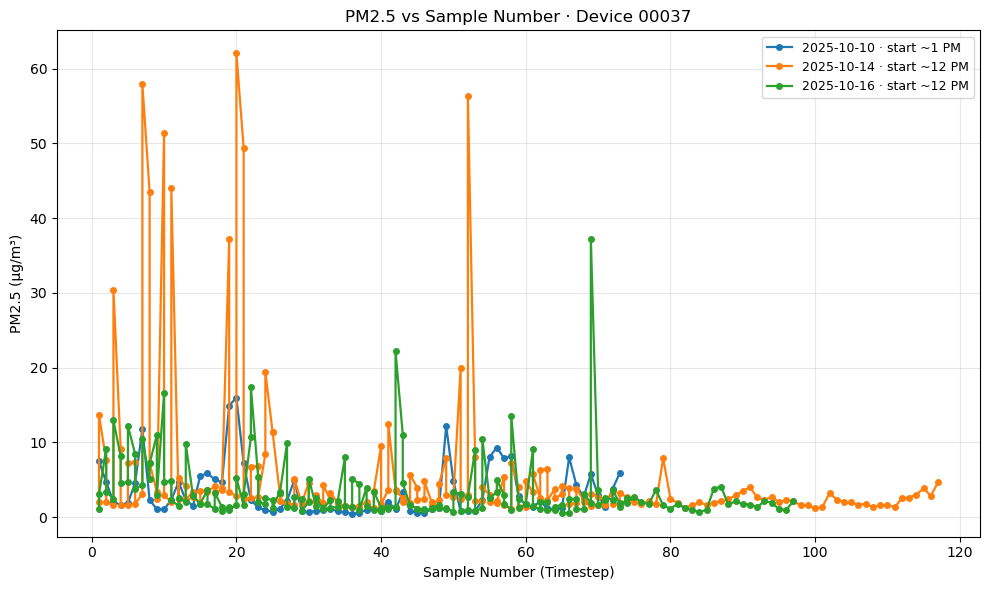

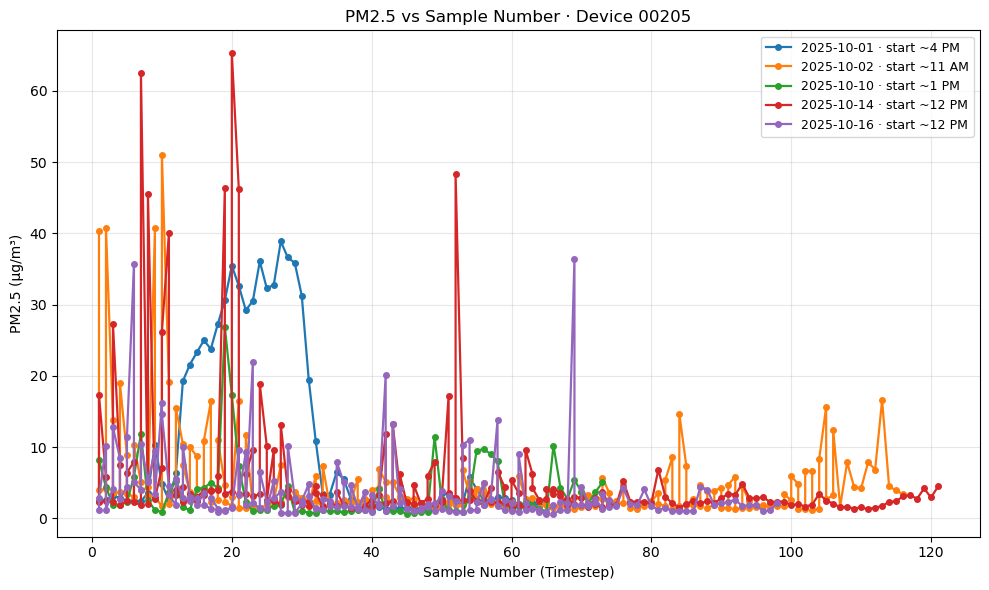

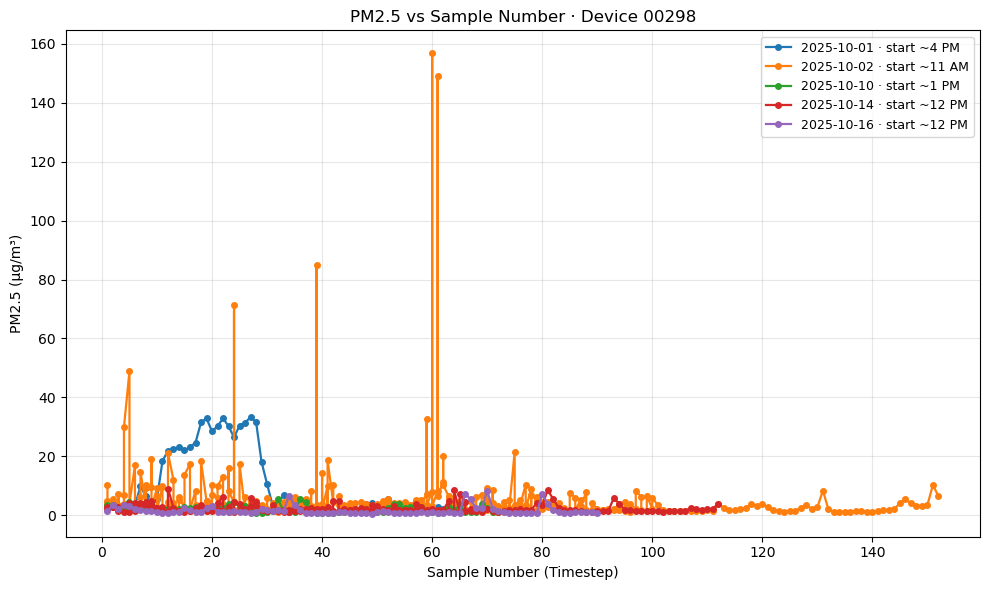

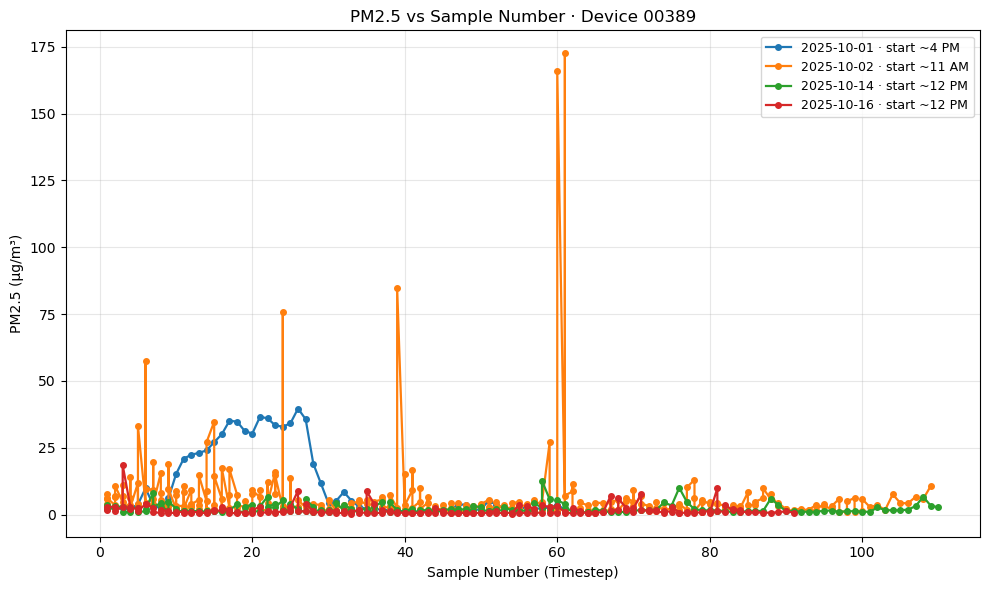


Generated 4 graphs (one per device)
All processing done in memory - no files created!


In [6]:


print("\nCreating graphs (displaying in notebook, not saving)...")

# Check if we have data
if len(data) == 0:
    print("⚠️  No data to plot!")
else:
    print(f"Total data points: {len(data)}")
    print(f"Devices found: {data['device'].unique()}")
    
    # Create one graph for each device
    for device, group in data.groupby("device", sort=True):
        
        plt.figure(figsize=(10, 6))
        
        # Plot each date on the same graph
        for date, date_data in group.groupby("date"):
            x = date_data["timestep"].to_numpy()
            y = date_data["pm25"].to_numpy()
            
            if len(x) == 0:
                continue
            
            # Sort by timestep
            order = np.argsort(x)
            x = x[order]
            y = y[order]
            
            # Get the hour for the label
            hour = date_data["hour_bucket"].iloc[0] if len(date_data) > 0 else "?"
            
            # Plot line
            label = f"{date} · start ~{hour}"
            plt.plot(x, y, label=label, linewidth=1.6, marker='o', markersize=4)
        
        # Format graph
        plt.xlabel("Sample Number (Timestep)")
        plt.ylabel("PM2.5 (µg/m³)")
        plt.title(f"PM2.5 vs Sample Number · Device {device}")
        plt.legend(loc="best", fontsize=9)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        
        # Display in notebook (no saving)
        plt.show()
    
    print(f"\nGenerated {len(data.groupby('device'))} graphs (one per device)")
    print("All processing done in memory - no files created!")

CREATE GRAPHS time steps vs pm2.5 ( all data from 10/10)


Creating graphs (displaying in notebook, not saving)...
Total data points: 2623
Devices found: ['00037' '00205' '00298' '00389']

📅 Filtering to dates >= 2025-10-10
Data points after filter: 1569
Dates included: ['2025-10-10', '2025-10-14', '2025-10-16']


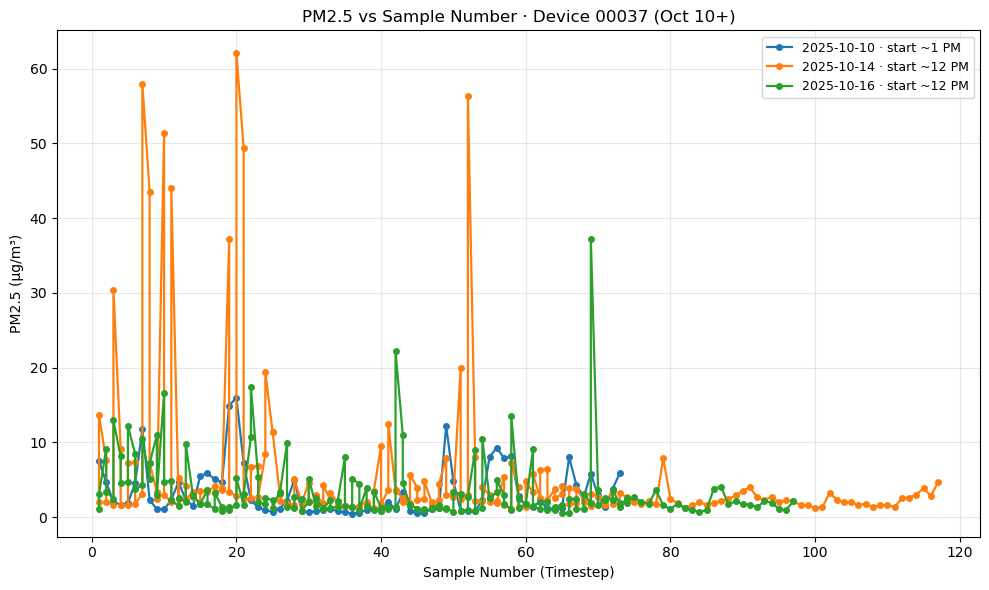

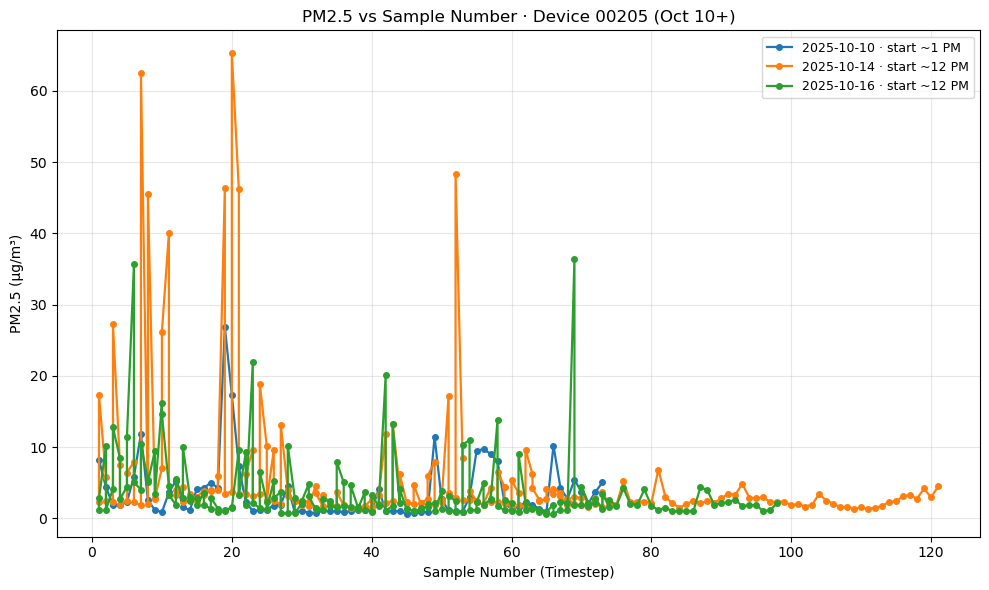

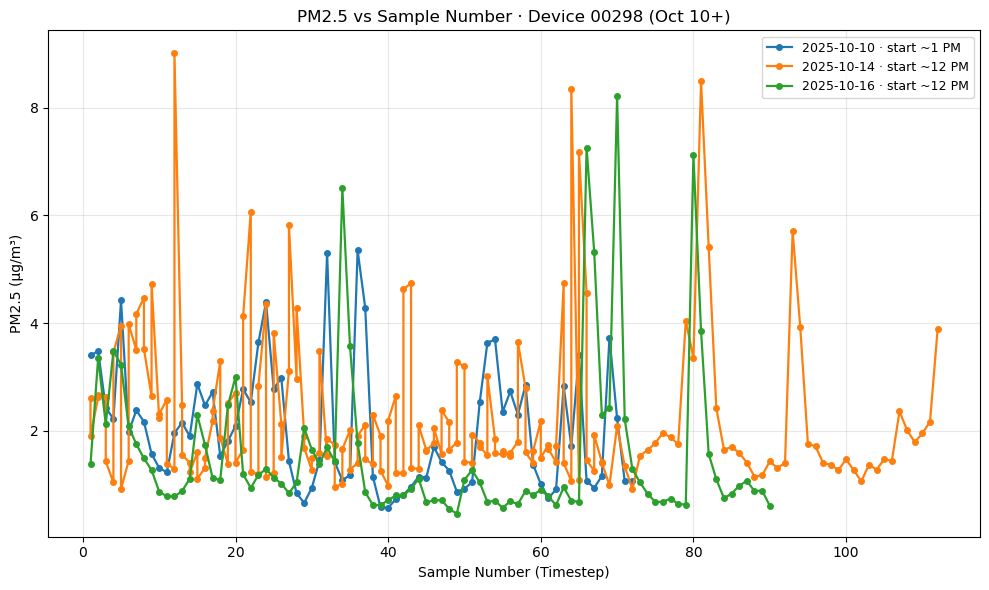

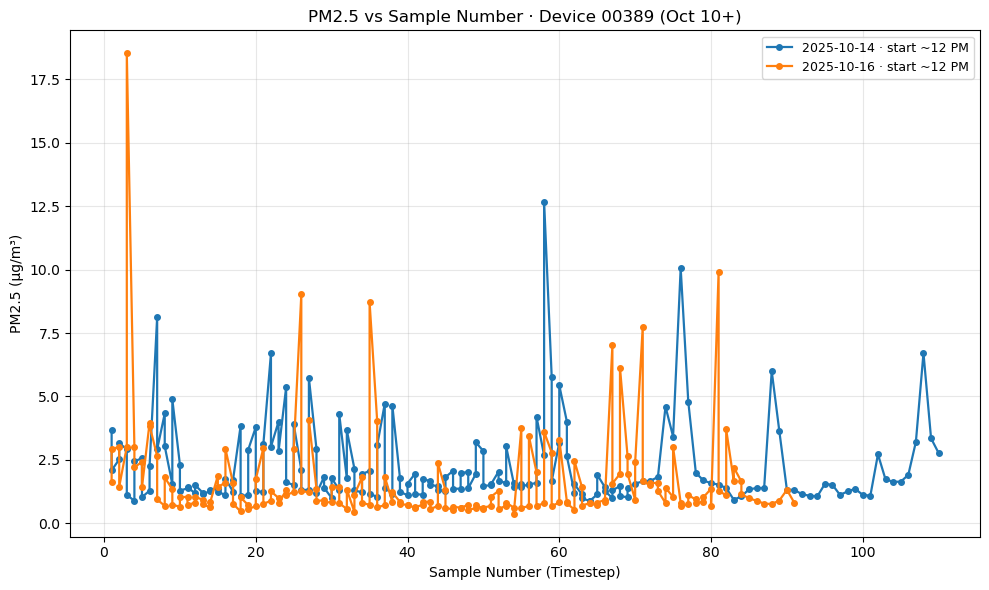


Generated 4 graphs (one per device)
All processing done in memory - no files created!


In [10]:

print("\nCreating graphs (displaying in notebook, not saving)...")

# Check if we have data
if len(data) == 0:
    print("⚠️  No data to plot!")
else:
    print(f"Total data points: {len(data)}")
    print(f"Devices found: {data['device'].unique()}")
    
    # FILTER: Only dates from Oct 10 onwards (including Oct 10)
    data_filtered = data[data['date'] >= '2025-10-10'].copy()
    
    print(f"\n📅 Filtering to dates >= 2025-10-10")
    print(f"Data points after filter: {len(data_filtered)}")
    print(f"Dates included: {sorted(data_filtered['date'].unique())}")
    
    if len(data_filtered) == 0:
        print("⚠️  No data after filtering!")
    else:
        # Create one graph for each device
        for device, group in data_filtered.groupby("device", sort=True):
            
            plt.figure(figsize=(10, 6))
            
            # Plot each date on the same graph
            for date, date_data in group.groupby("date"):
                x = date_data["timestep"].to_numpy()
                y = date_data["pm25"].to_numpy()
                
                if len(x) == 0:
                    continue
                
                # Sort by timestep
                order = np.argsort(x)
                x = x[order]
                y = y[order]
                
                # Get the hour for the label
                hour = date_data["hour_bucket"].iloc[0] if len(date_data) > 0 else "?"
                
                # Plot line
                label = f"{date} · start ~{hour}"
                plt.plot(x, y, label=label, linewidth=1.6, marker='o', markersize=4)
            
            # Format graph
            plt.xlabel("Sample Number (Timestep)")
            plt.ylabel("PM2.5 (µg/m³)")
            plt.title(f"PM2.5 vs Sample Number · Device {device} (Oct 10+)")
            plt.legend(loc="best", fontsize=9)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            
            # Display in notebook (no saving)
            plt.show()
        
        print(f"\nGenerated {len(data_filtered.groupby('device'))} graphs (one per device)")
        print("All processing done in memory - no files created!")